In [7]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from import_KK import *
DeviceStrategy_CPU()
from preprocessing_KK import *
from description_KK import *
from algorithm_KK import *
from evaluation_KK import *

# Hyperparameters

In [76]:
# hyperparameters
test_criteria = '2023-01-01'
SEQUENCE = 7
KERNEL_SIZE = 2
STRIDE = 1
POOL_SIZE = 1
POOL_STRIDE = 1
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 32
EPOCHS = 500
VERBOSE = 0
################
EARLYSTOP_PATIENT = 200
MONITOR = 'val_loss'
################

# 데이터로딩
file_location = os.path.join(os.getcwd(), 'Data', 'ageism_survey_KK.xlsx')
df = pd.read_excel(file_location, sheet_name='GT_Trend', index_col='Time')
df_global = df[['Ageism']].copy()
df_local = df[['고령화']].copy()

# Modeling

Numerical Scaling... ( 2023-09-23 03:18:37.713253 )
X_train: (113, 7) Y_train: (113, 1)
X_test: (8, 7) Y_test: (8, 1)
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_214 (Dense)           (None, 256)               2048      
                                                                 
 dropout_199 (Dropout)       (None, 256)               0         
                                                                 
 dense_215 (Dense)           (None, 128)               32896     
                                                                 
 dropout_200 (Dropout)       (None, 128)               0         
                                                                 
 dense_216 (Dense)           (None, 64)                8256      
      

Training:   0%|                                                                               0/500 ETA: ?s,  …

Epoch 356: early stopping


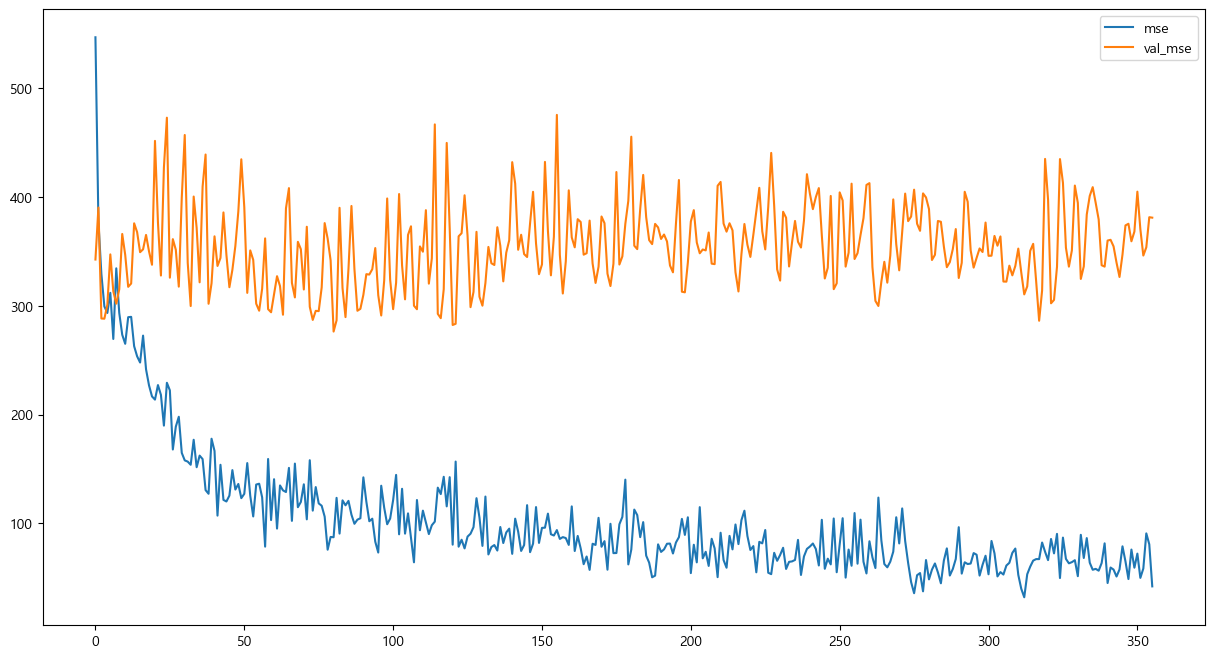

1/1 [==============================] - 0s 10ms/step
Performance: 


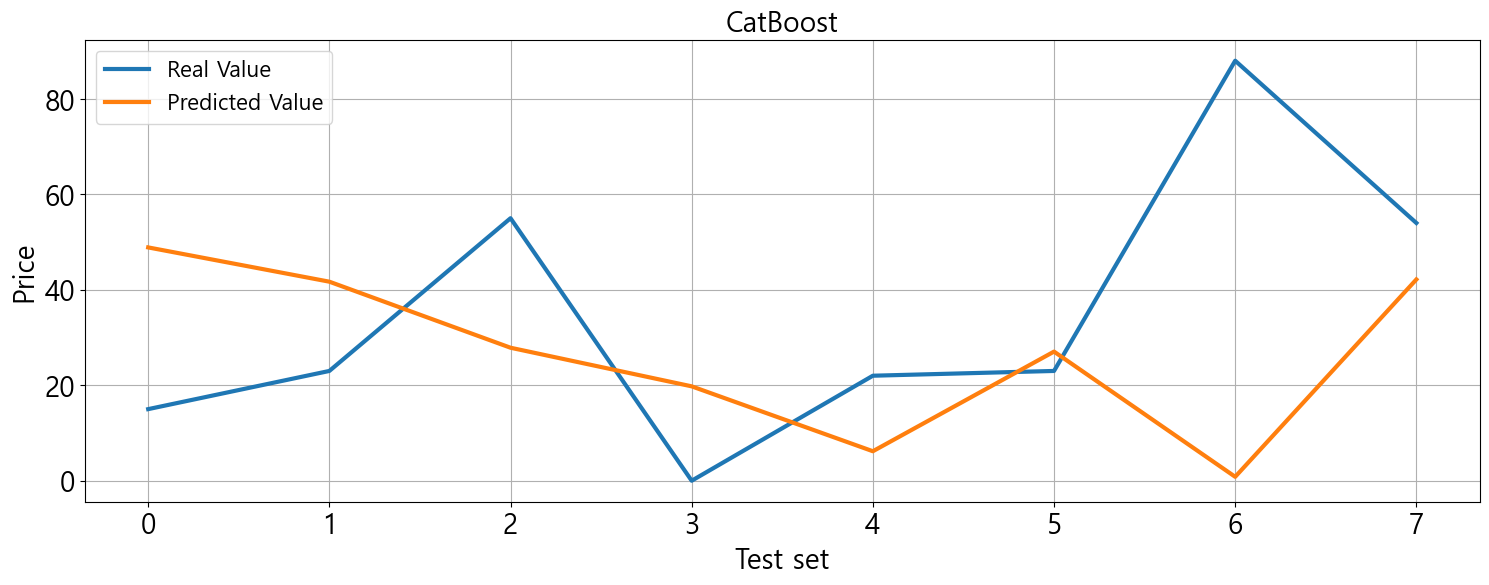

,MAE,MSE,MAPE
Score,27.2971,"1,328.9777","11,132,127,881,986,048.0000"


,MAE,MSE,MAPE
Score,6.3465,170.2905,"8,875,571,276,659,788.0000"


In [82]:
# 전처리
X, Y = reshape_1Dto2Dseq(df_global, SEQUENCE)
X_train, Y_train = X.loc[X.index < test_criteria,:], Y.loc[Y.index < test_criteria,:]
X_test, Y_test = X.loc[X.index >= test_criteria,:], Y.loc[Y.index >= test_criteria,:]
X_train, X_test = feature_num_scaling_trte(preprocessing.MinMaxScaler(), X_train, X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
model = modeling_MLP(X_train, Y_train, HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                     LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, save_name = learning(model, X_train, X_test, Y_train,
                            BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                            MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                            HISTORY_METRICS=METRICS)
Score_te, Score_trte = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME='MLP')
display(Score_te, Score_trte)

Numerical Scaling... ( 2023-09-23 03:18:45.473085 )
X_train: (113, 7, 1) Y_train: (113, 1)
X_test: (8, 7, 1) Y_test: (8, 1)
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 7, 1)]            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 7, 128)            384       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 7, 128)           0         
 g1D)                                                            
                                                                 
 dropout_204 (Dropout)       (None, 7, 128)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 7, 256)            65792     
                                                                 


Training:   0%|                                                                               0/500 ETA: ?s,  …

Epoch 201: early stopping


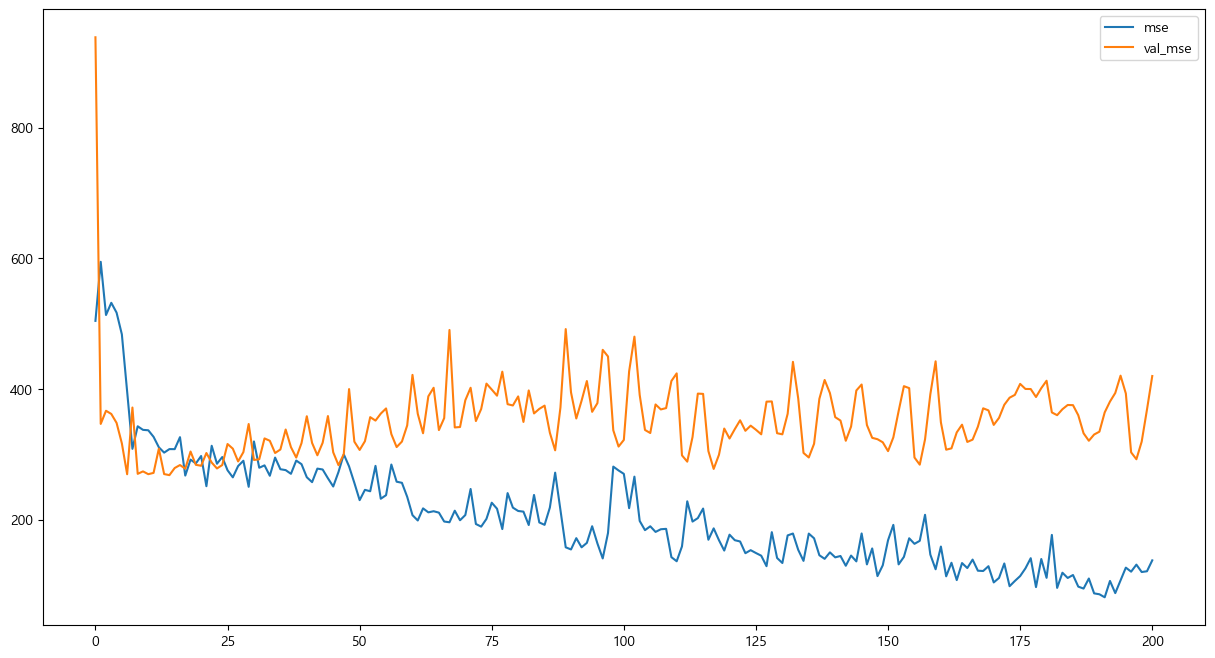

1/1 [==============================] - 0s 11ms/step
Performance: 


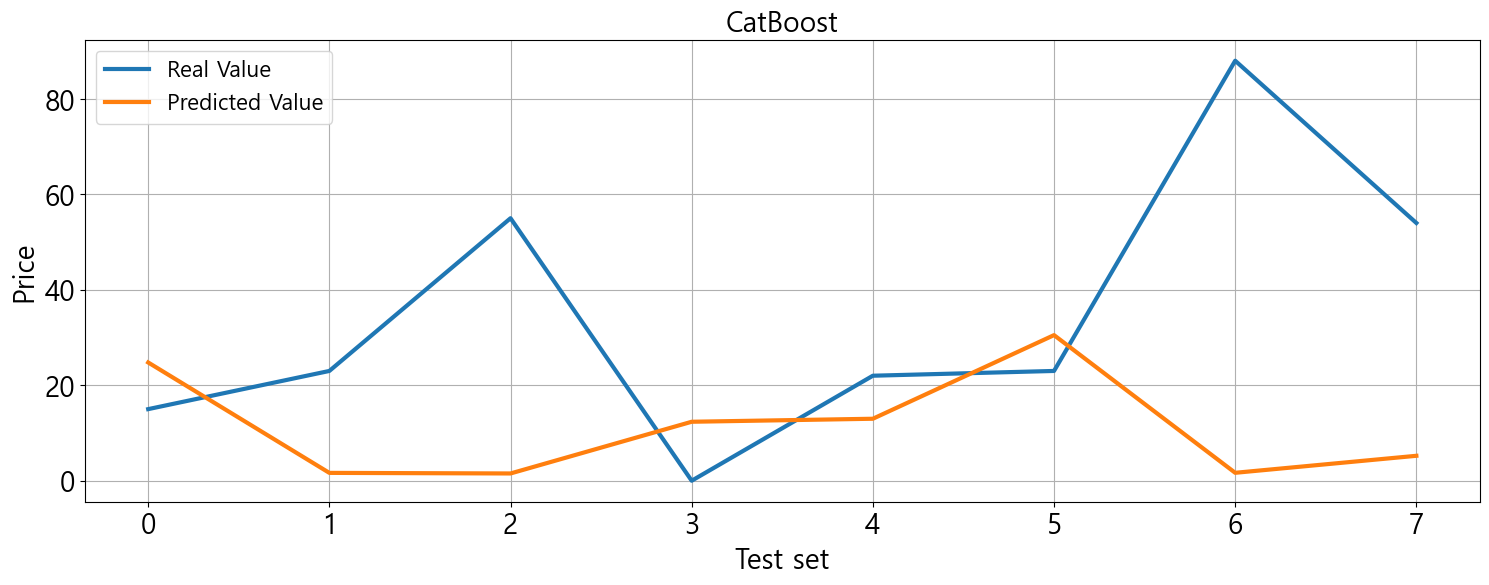

,MAE,MSE,MAPE
Score,31.0756,"1,691.9616","6,954,992,476,880,896.0000"


,MAE,MSE,MAPE
Score,8.3455,219.0344,"12,608,650,842,741,092.0000"


In [83]:
# 전처리
X, Y = reshape_1Dto2Dseq(df_global, SEQUENCE)
X_train, Y_train = X.loc[X.index < test_criteria,:], Y.loc[Y.index < test_criteria,:]
X_test, Y_test = X.loc[X.index >= test_criteria,:], Y.loc[Y.index >= test_criteria,:]
X_train, X_test = feature_num_scaling_trte(preprocessing.MinMaxScaler(), X_train, X_test)
X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test = X_test.values.reshape(-1, X_test.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# CNN
model = modeling_CNN1D(X_train, Y_train, HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                       KERNEL_SIZE=KERNEL_SIZE, STRIDE=STRIDE, POOL_SIZE=POOL_SIZE, POOL_STRIDE=POOL_STRIDE,
                       LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, save_name = learning(model, X_train, X_test, Y_train,
                            BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                            MONITOR=MONITOR, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                            HISTORY_METRICS=METRICS)
Score_te, Score_trte = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME='CNN1D')
display(Score_te, Score_trte)

In [ ]:
# moving window 방식으로 1개씩 예측하는 모듈 생성